In [10]:
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from scipy.stats import ks_2samp
from sklearn.metrics import classification_report, accuracy_score, recall_score, roc_auc_score, roc_curve

# Cargamos y transformamos nuestros datos

In [3]:
df = pd.read_csv('credit_card_default.csv')

# transformacion ----------------------------
# Rename
df.rename(columns=lambda x: x.lower(), inplace=True) # pasa a minusculas los headers
df.rename(columns={'default payment next month':'default'}, inplace=True) # cambiamos el nombre de una columna
df.rename(columns={'pay_0':'pay_1'}, inplace=True) # cambiamos el nombre de una columna

# etiquetas de tipos de variables
bill_amt_features = ['bill_amt'+str(i) for i in range(1,7)]
pay_amt_features = ['pay_amt'+str(i) for i in range(1,7)]
numerical_features = ['limit_bal', 'age'] + bill_amt_features + pay_amt_features

# transformando el tipo de variables
df['male'] = (df['sex'] == 1).astype('int')
df['female'] = (df['sex'] == 2).astype('int')
df['grad_school'] = (df['education'] == 1).astype('int')
df['university'] = (df['education'] == 2).astype('int')
df['high_school'] = (df['education'] == 3).astype('int')
df['married'] = (df['marriage'] == 1).astype('int')

# transfromamos los valores con -1 o -2 a 0
pay_features = ['pay_'+str(i) for i in range(1,7)]
for x in pay_features:
    df.loc[df[x] <= 0, x] = 0

# creamos variables binarias
delayed_features = ['delayed_' + str(i) for i in range(1,7)]
for pay, delayed in zip(pay_features, delayed_features):
    df[delayed] = (df[pay] > 0).astype('int')

# creamos la columna de la suma de los atrasos de los ultimos meses
df['months_delayed'] = df[delayed_features].sum(axis=1)

# por ultimo solo nos quedamos con las variables de interes
numerical_features = numerical_features + ['months_delayed']
binary_features = ['male','female','married','grad_school', 'university','high_school']
x = df[numerical_features + binary_features]
y = df['default'].astype('int')

# dividimos nuestros datos en train y test, y tambien escalamos nuestros datos

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101)

# escalamos los datos (solo las columnas numericas)
scaler = StandardScaler()
x_train[numerical_features] = scaler.fit_transform(x_train[numerical_features])
x_test[numerical_features] = scaler.transform(x_test[numerical_features])

In [6]:
x_train.head()

,limit_bal,age,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,...,pay_amt4,pay_amt5,pay_amt6,months_delayed,male,female,married,grad_school,university,high_school
12160,-1.065331,-0.163934,-0.689649,-0.677825,-0.666959,-0.651430,-0.640844,-0.628745,-0.277692,-0.239892,...,-0.287068,-0.283509,-0.291946,0.099721,0,1,1,0,1,0
1100,0.321616,1.138318,-0.616481,-0.613657,-0.388329,-0.405881,-0.626207,-0.647999,-0.334689,0.449626,...,-0.163797,-0.293644,-0.071368,0.737596,0,1,0,0,0,1
22225,-0.680068,-0.815059,0.262167,0.318235,0.380530,0.491573,0.561938,0.599624,-0.150647,-0.100467,...,-0.132172,-0.124146,-0.132027,-0.538154,0,1,0,1,0,0
6385,0.552774,0.053108,-0.695212,-0.439784,-0.411105,-0.404381,-0.347916,-0.300306,0.704023,-0.160221,...,-0.183804,-0.117772,-0.181657,0.099721,0,1,0,1,0,0
22930,-0.603015,-0.272455,-0.643542,-0.572138,-0.547191,-0.492989,-0.644520,-0.652010,-0.046700,-0.188703,...,-0.236146,-0.309007,0.195091,-0.538154,0,1,1,0,1,0


# desarrollamos el modelo

In [ ]:
model = LogisticRegression()
# entrenamos el modelo
model.fit(x_train, y_train)

LogisticRegression()

In [11]:
y_pred_train = model.predict(x_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88     16306
           1       0.64      0.27      0.38      4694

    accuracy                           0.80     21000
   macro avg       0.73      0.61      0.63     21000
weighted avg       0.78      0.80      0.77     21000



In [12]:
y_pred_test = model.predict(x_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.82      0.96      0.89      7058
           1       0.64      0.25      0.36      1942

    accuracy                           0.81      9000
   macro avg       0.73      0.61      0.63      9000
weighted avg       0.78      0.81      0.77      9000



In [ ]:
y_pred_proba_train = model.predict_proba(x_train)[:, 1]
y_pred_proba_test = model.predict_proba(x_test)[:, 1]

# calculamos las metricas para el entrenamiento
auc_roc_train = roc_auc_score(y_train, y_pred_proba_train)
ks_stat_train, p_value_train = ks_2samp(y_pred_proba_train[y_train == 0], y_pred_proba_train[y_train == 1])
gini_train = 2*auc_roc_train-1

# calculamos las metricas para validacion
auc_roc_test = roc_auc_score(y_test, y_pred_proba_test)
ks_stat_test, p_value_test = ks_2samp(y_pred_proba_test[y_test == 0], y_pred_proba_test[y_test == 1])
gini_test = 2*auc_roc_test-1

print("Metricas para el entrenamiento: \n" + f"AUC = {round(auc_roc_train,2)} \n" + f"KS = {round(ks_stat_train,2)} \n" + f"GINI = {round(gini_train,2)}")
print("---------------------------------")
print("Metricas para la validación: \n" + f"AUC = {round(auc_roc_test,2)} \n" + f"KS = {round(ks_stat_test,2)} \n" + f"GINI = {round(gini_test,2)}")

Metricas para el entrenamiento: 
AUC = 0.76 
KS = 0.41 
GINI = 0.52
Metricas para la validación: 
AUC = 0.75 
KS = 0.39 
GINI = 0.49


podemos observar que obtenemos resultados muy similares con nuestros otros modelos

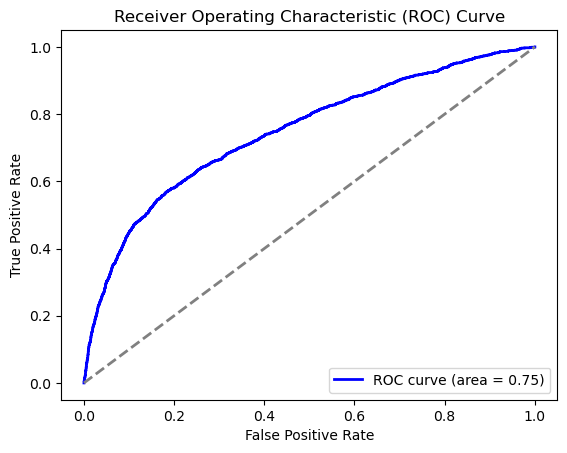

In [16]:
# obtenemos los valores de la curva ROC
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba_test)

# graficamos la cruva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc_roc_test:.2f})')
plt.plot([0,1], [0,1], color='gray', lw=2, linestyle="--")
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Cuales son nuestras variables finalistas?

In [17]:
vars = ['bill_amt3', 'high_school', 'bill_amt1', 'female', 'male', 'age', 'married', 'university', 'bill_amt2', 'grad_school']
x_train_finalitas = x_train.drop(columns=vars)
x_test_finalistas = x_test.drop(columns=vars)
x_train_finalitas.head()

,limit_bal,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,months_delayed
12160,-1.065331,-0.651430,-0.640844,-0.628745,-0.277692,-0.239892,-0.211845,-0.287068,-0.283509,-0.291946,0.099721
1100,0.321616,-0.405881,-0.626207,-0.647999,-0.334689,0.449626,-0.288999,-0.163797,-0.293644,-0.071368,0.737596
22225,-0.680068,0.491573,0.561938,0.599624,-0.150647,-0.100467,-0.109697,-0.132172,-0.124146,-0.132027,-0.538154
6385,0.552774,-0.404381,-0.347916,-0.300306,0.704023,-0.160221,-0.180331,-0.183804,-0.117772,-0.181657,0.099721
22930,-0.603015,-0.492989,-0.644520,-0.652010,-0.046700,-0.188703,-0.125997,-0.236146,-0.309007,0.195091,-0.538154


entrenemos un modelo ahora con las variables restantes

In [18]:
model_final = LogisticRegression()
# entrenamos el modelo
model_final.fit(x_train_finalitas, y_train)
# hacemos la clasificacion
y_pred_train_f = model_final.predict(x_train_finalitas)
y_pred_test_f = model_final.predict(x_test_finalistas)

In [19]:
print(classification_report(y_train, y_pred_train_f))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88     16306
           1       0.64      0.25      0.36      4694

    accuracy                           0.80     21000
   macro avg       0.73      0.61      0.62     21000
weighted avg       0.78      0.80      0.77     21000



In [21]:
print(classification_report(y_test, y_pred_test_f))

              precision    recall  f1-score   support

           0       0.82      0.96      0.89      7058
           1       0.65      0.24      0.35      1942

    accuracy                           0.81      9000
   macro avg       0.74      0.60      0.62      9000
weighted avg       0.79      0.81      0.77      9000



In [22]:
y_pred_proba_train_f = model_final.predict_proba(x_train_finalitas)[:, 1]
y_pred_proba_test_f = model_final.predict_proba(x_test_finalistas)[:, 1]

# calculamos las metricas para el entrenamiento
auc_roc_train_f = roc_auc_score(y_train, y_pred_proba_train_f)
ks_stat_train_f, p_value_train_f = ks_2samp(y_pred_proba_train_f[y_train == 0], y_pred_proba_train_f[y_train == 1])
gini_train_f = 2*auc_roc_train_f-1

# calculamos las metricas para validacion
auc_roc_test_f = roc_auc_score(y_test, y_pred_proba_test_f)
ks_stat_test_f, p_value_test_f = ks_2samp(y_pred_proba_test_f[y_test == 0], y_pred_proba_test_f[y_test == 1])
gini_test_f = 2*auc_roc_test_f-1

print("Metricas para el entrenamiento: \n" + f"AUC = {round(auc_roc_train_f,2)} \n" + f"KS = {round(ks_stat_train_f,2)} \n" + f"GINI = {round(gini_train_f,2)}")
print("---------------------------------")
print("Metricas para la validación: \n" + f"AUC = {round(auc_roc_test_f,2)} \n" + f"KS = {round(ks_stat_test_f,2)} \n" + f"GINI = {round(gini_test_f,2)}")

Metricas para el entrenamiento: 
AUC = 0.75 
KS = 0.41 
GINI = 0.5
---------------------------------
Metricas para la validación: 
AUC = 0.74 
KS = 0.4 
GINI = 0.49


las metricas son casi las mismas al haber quitado varias variables, entonces estas variables no nos prorporcionaban informacion extra

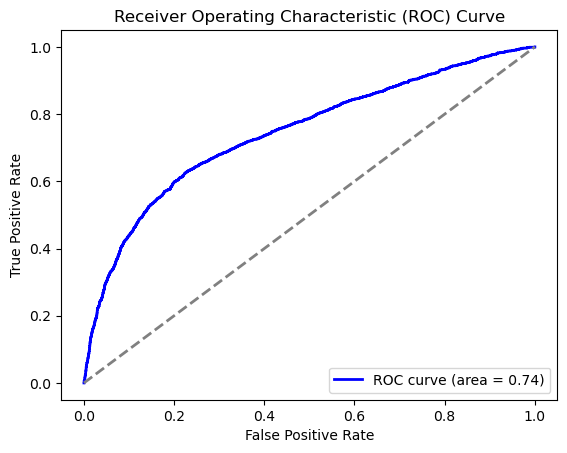

In [23]:
# obtenemos los valores de la curva ROC
fpr_f, tpr_f, threshold_f = roc_curve(y_test, y_pred_proba_test_f)

# graficamos la cruva ROC
plt.figure()
plt.plot(fpr_f, tpr_f, color='blue', lw=2, label=f'ROC curve (area = {auc_roc_test_f:.2f})')
plt.plot([0,1], [0,1], color='gray', lw=2, linestyle="--")
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [24]:
numerical_features

['limit_bal',
 'age',
 'bill_amt1',
 'bill_amt2',
 'bill_amt3',
 'bill_amt4',
 'bill_amt5',
 'bill_amt6',
 'pay_amt1',
 'pay_amt2',
 'pay_amt3',
 'pay_amt4',
 'pay_amt5',
 'pay_amt6',
 'months_delayed']

En conclusion, nuestras variables finalistas serian:

**limit_bal**, **bill_amt4**, **bill_amt5**, **bill_amt6**, **pay_amt1**, **pay_amt2**, **pay_amt3**, **pay_amt4**, **pay_amt5**, **pay_amt6** y **months_delayed**

y las variables que quitamos en su mayoria fueorn variables binarias que no aportaban nada extra, mas algunas variables continuas que no han afectado al modelo
